## `STEPS - Short-Term Ensemble Prediction System` w/ `PySteps`

* This notebook implements probabilistic nowcasts using PySteps implementation of `STEPS`.

* The notebook experiments with both **roll-out** and **single-shot** examples of nowcasting.

[1] **roll-out process:**
```
# [ [x] [x] [x] [x] ] --> [y1]
# [     [x] [x] [x]       [y1]] --> [y2]
# [         [x] [x]       [y1]      [y2]] --> [y3]
# [             [x]       [y1]      [y2]      [y3]] --> [y4]
# ...
```

[2] **single-shot process:**
```
# [ [x] [x] [x] [x] ] --> [y1][y2][y3][y4][y5][y6][y7][y8]
```

In [1]:
import os
import time
from pathlib import Path
from typing import Any, Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from IPython.display import clear_output
from matplotlib.colors import ListedColormap
from scipy import io
from torch.utils.data import DataLoader
from tqdm import tqdm

from rainnow.src.convlstm_trainer import create_eval_loader
from rainnow.src.datasets import IMERGDataset
from rainnow.src.models.pysteps_steps import PyStepsSTEPSNowcastModel
from rainnow.src.plotting import plot_a_sequence
from rainnow.src.utilities.loading import load_imerg_datamodule_from_config
from rainnow.src.utilities.utils import get_device

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tensordict/_pytree.py:147: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  register_pytree_node(


Pysteps configuration file found at: /teamspace/studios/this_studio/.pysteps/pystepsrc



#### `helpers.`

In [2]:
# ** DIR helpers **
BASE_PATH = "/teamspace/studios/this_studio"

CKPT_BASE_PATH = f"{BASE_PATH}/DYffcast/rainnow/results/"
CONFIGS_BASE_PATH = f"{BASE_PATH}/DYffcast/rainnow/src/dyffusion/configs/"

CKPT_DIR = "checkpoints"
CKPT_CFG_NAME = "hparams.yaml"
DATAMODULE_CONFIG_NAME = "imerg_precipitation.yaml"
# whether or not to get last.ckpt or to get the "best model" ckpt (the other one in the folder).
GET_LAST = False

# ** Dataloader Params **
BATCH_SIZE = 12
NUM_WORKERS = 0

INPUT_SEQUENCE_LENGTH = 4
OUTPUT_SEQUENCE_LENGTH = 1

# ** plotting helpers **
# cmap = io.loadmat("../../src/utilities/cmaps/colormap.mat")
cmap = io.loadmat(f"{BASE_PATH}/DYffcast/rainnow/src/utilities/cmaps/colormap.mat")
rain_cmap = ListedColormap(cmap["Cmap_rain"])
global_params = {"font.size": 8}  # , "font.family": "Times New Roman"}
plt_params = {"wspace": 0.1, "hspace": 0.15}
ylabel_params = {"ha": "right", "va": "bottom", "labelpad": 1, "fontsize": 7.5}

# ** get device **
device = get_device()

Cuda installed! Running on GPU! (device = cuda)


#### `Instantiate + Load in the datamodule`

In [3]:
datamodule = load_imerg_datamodule_from_config(
    cfg_base_path=CONFIGS_BASE_PATH,
    cfg_name=DATAMODULE_CONFIG_NAME,
    overrides={
        "boxes": ["1,0"],
        # "boxes": ["0,0", "1,0", "2,0", "2,1"],
        "window": 1,
        "horizon": 8,
        "prediction_horizon": 8,
        "sequence_dt": 1,
        "normalization": None,  # set normalisation to None. Need raw mm/h for the STEPS nowcast.
    },
)

In [4]:
# only need prior images for PySteps, no training required.
datamodule.setup("predict")

predict_dataset = IMERGDataset(
    datamodule, "predict", sequence_length=INPUT_SEQUENCE_LENGTH, target_length=OUTPUT_SEQUENCE_LENGTH
)
predict_loader = DataLoader(
    dataset=predict_dataset, batch_size=6, num_workers=NUM_WORKERS, shuffle=False
)

[2024-12-23 10:33:01][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-12-23 10:33:01][imerg_precipitation.py][INFO] --> predict data split: [202303080000, 202303100000]
[2024-12-23 10:33:02][torch_datasets.py][INFO] --> creating PREDICT tensor dataset.
[2024-12-23 10:33:02][abstract_datamodule.py][INFO] -->  Dataset predict size: 11


In [5]:
# test train dataset.
X_dummy, y_dummy = predict_dataset.__getitem__(0)
print(X_dummy.size(), y_dummy.size())

assert X_dummy.size() == torch.Size([INPUT_SEQUENCE_LENGTH, 1, 128, 128])
assert y_dummy.size() == torch.Size([1, 1, 128, 128])

torch.Size([4, 1, 128, 128]) torch.Size([1, 1, 128, 128])


torch.Size([6, 4, 1, 128, 128]) torch.Size([6, 1, 1, 128, 128])


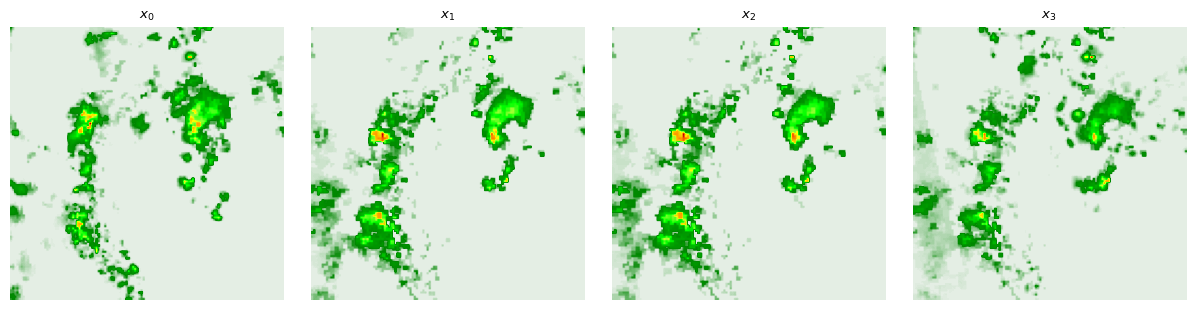

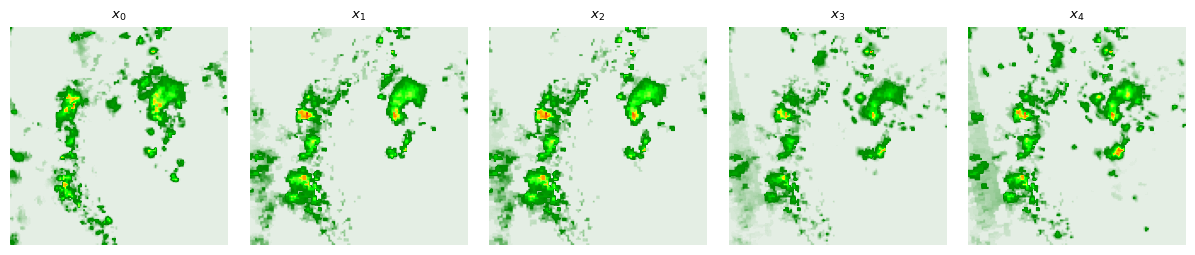

In [6]:
# plot a batch.
dummy_batch = next(iter(predict_loader))
dummy_inputs, dummy_target = dummy_batch
print(dummy_inputs.size(), dummy_target.size())


# plot the input sequence.
b = 0
plot_a_sequence(
    X=dummy_inputs,
    b=b,
    global_params=global_params,
    plot_params={"cmap": rain_cmap},
    layout_params=plt_params,
)

# plot the inputs & target.
plot_a_sequence(
    X=torch.cat([dummy_inputs[b, ...], dummy_target[b, ...]], dim=0).unsqueeze(0),
    b=b,
    global_params=global_params,
    plot_params={"cmap": rain_cmap},
    layout_params=plt_params,
)

### `STEPS` in `PySteps`

Computing STEPS nowcast
-----------------------

Inputs
------
input dimensions: 128x128
km/pixel:         10
time step:        30 minutes

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
noise generator:        nonparametric
noise adjustment:       no
velocity perturbator:   bps
conditional statistics: no
precip. mask method:    incremental
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     1
ensemble size:            10
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
velocity perturbations, parallel:      10.88,0.23,-7.68
velocity perturbations, perpendicular: 5.76,0.31,-2.72
precip. intensity threshold: -15
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-----------------------------------------
|

done.


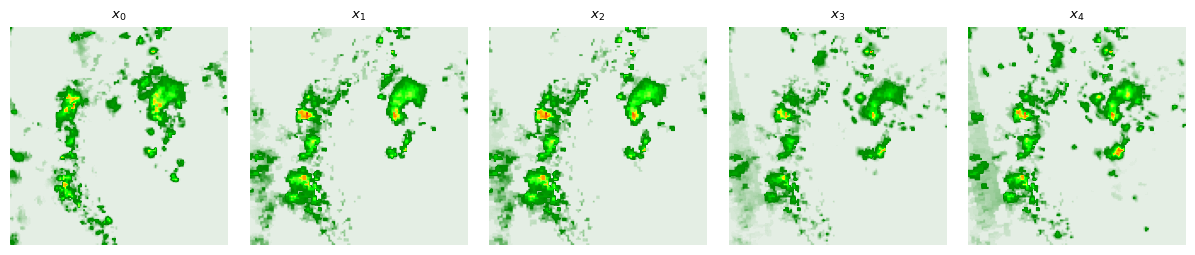

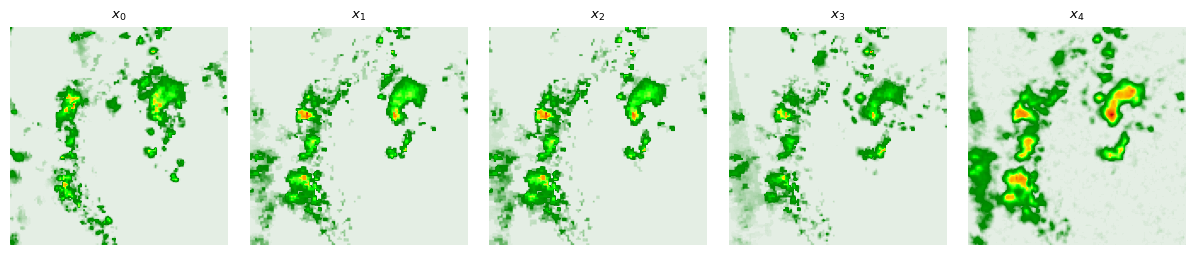

In [7]:
b = 0
pysteps_model = PyStepsSTEPSNowcastModel(
    input_precip_sequence=dummy_inputs[b, ...],
    input_dims=(1, 128, 128),  # c, h, w.
    horizon=30 * 1,  # in min
    data_time_interval=30,
    data_km_per_pixel_resolution=10,
    num_ensemble=10,
    transform_mm_h_to_dBR=True,
)

R_f = pysteps_model.nowcast(
    mm_h_precip_threshold=0.1,
    dBR_precip_threshold=-15,
    n_cascade_levels=6,
    noise_method="nonparametric",  # adds stochastic noise to represent growth/decay
    vel_pert_method="bps",  # If set to None, the advection field is not perturbed.
    mask_method="incremental",  # "sprog",
    seed=42,
)

# plot nowcasts.
plot_a_sequence(
    X=torch.cat([dummy_inputs, dummy_target], dim=1),
    b=0,
    global_params=global_params,
    plot_params={"cmap": rain_cmap},
    layout_params=plt_params,
)
plot_a_sequence(
    X=torch.cat([dummy_inputs[b, ...], torch.from_numpy(R_f).mean(dim=0).unsqueeze(1)], dim=0).unsqueeze(
        0
    ),
    b=0,
    global_params=global_params,
    plot_params={"cmap": rain_cmap},
    layout_params=plt_params,
)

#### `create Predict dataloader`

In [8]:
datamodule.setup("predict")

predict_dataset = IMERGDataset(
    datamodule, "predict", sequence_length=INPUT_SEQUENCE_LENGTH, target_length=OUTPUT_SEQUENCE_LENGTH
)
predict_loader = DataLoader(
    dataset=predict_dataset, batch_size=6, num_workers=NUM_WORKERS, shuffle=False
)

[2024-12-23 10:33:04][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-12-23 10:33:04][imerg_precipitation.py][INFO] --> predict data split: [202303080000, 202303100000]
[2024-12-23 10:33:05][torch_datasets.py][INFO] --> creating PREDICT tensor dataset.
[2024-12-23 10:33:05][abstract_datamodule.py][INFO] -->  Dataset predict size: 11


#### `Eval predictions`

In [9]:
# ** create the eval dataloader **
eval_loader, _ = create_eval_loader(
    data_loader=predict_loader, horizon=8, input_sequence_length=4, img_dims=(128, 128)
)

** eval loader (INFO) **
Num samples = 11 w/ dims: torch.Size([12, 1, 128, 128])



### `STEPS roll-out`

In [ ]:
# need to generate the horizon using STEPS.
# using STEPS as a roll-out tool for better comparison.

# roll-out process:
# [ [x] [x] [x] [x] ] --> [y1]
# [     [x] [x] [x]       [y1]] --> [y2]
# [         [x] [x]       [y1]      [y2]] --> [y3]
# [             [x]       [y1]      [y2]      [y3]] --> [y4]
# ...

results = []
for e, (X, target) in enumerate(eval_loader):
    print(f"\n*** Generate Nowcast ({e+1}) ***\n")
    s = time.time()
    predictions = {}
    for t in range(target.size(0)):
        # instantiate PySteps model using X.
        pysteps_model = PyStepsSTEPSNowcastModel(
            input_precip_sequence=X,
            input_dims=(1, 128, 128),  # c, h, w.
            horizon=30 * 1,  # in min
            data_time_interval=30,
            data_km_per_pixel_resolution=10,
            num_ensemble=10,
            transform_mm_h_to_dBR=True,
        )

        # STEPS nowcast.
        R_f = pysteps_model.nowcast(
            mm_h_precip_threshold=0.1,
            dBR_precip_threshold=-15,
            n_cascade_levels=6,
            noise_method="nonparametric",  # adds stochastic noise to represent growth/decay.
            vel_pert_method="bps",  # If set to None, the advection field is not perturbed.
            mask_method="incremental",  # "sprog"
            seed=42,
        )

        # get mean of ensemble.
        pred = np.mean(R_f, axis=0)

        # store the prediction.
        predictions[f"t{t+1}"] = torch.from_numpy(pred)

        # update the inputs with the last pred.
        X = torch.concat([X[1:, ...], torch.from_numpy(pred).unsqueeze(0)], dim=0)

    print(f"time taken = {time.time() - s}s")
    results.append([target, predictions])

    # clear STEPS outputs.
    clear_output(wait=True)

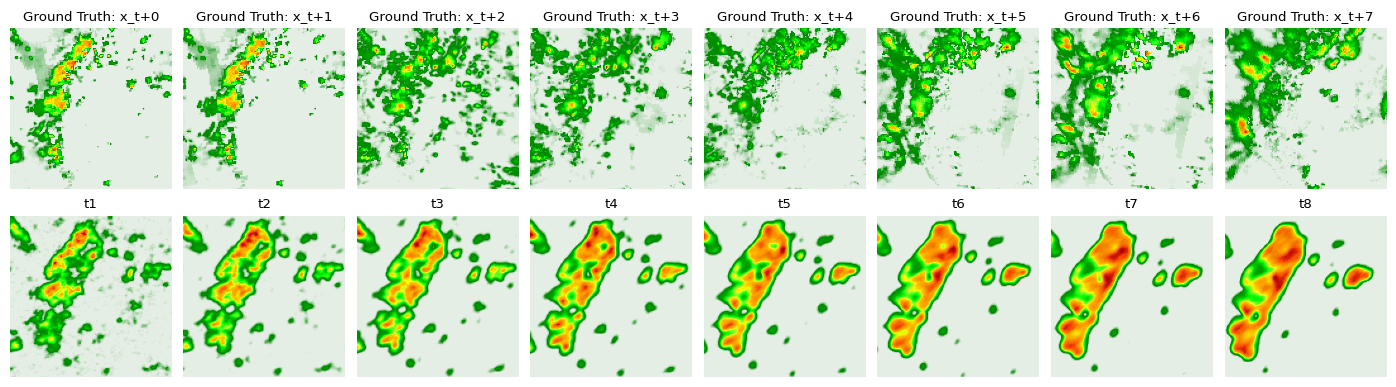

In [11]:
# plot the predictions:
c = 0
figsize = (14, 4)
plot_params = {"cmap": rain_cmap, "vmin": 2, "vmax": 18}

idx = 6
targets, predictions = results[idx]

fig, axs = plt.subplots(2, targets.size(0), figsize=figsize)
plt.rcParams.update(global_params)

# plot ground truth in the 1st row.
for j in range(targets.size(0)):
    axs[0, j].imshow(targets[j, c, ...], **{"cmap": rain_cmap})
    axs[0, j].set_title(f"Ground Truth: x_t+{j}")

# plot predictions.
for e, (k, pred) in enumerate(predictions.items()):
    axs[1, e].imshow(pred[c, :, :], **{"cmap": rain_cmap})
    axs[1, e].set_title(f"{k}")
for ax in axs.flatten():
    ax.axis("off")
plt.tight_layout()

### `STEPS single-shot`

In [ ]:
# single-shot process:
# [ [x] [x] [x] [x] ] --> [y1][y2][y3][y4][y5][y6][y7][y8]

results = []
for e, (X, target) in enumerate(eval_loader):
    print(f"\n*** Generate Nowcast ({e+1}) ***\n")
    predictions = {}
    # instantiate PySteps model using X.
    pysteps_model = PyStepsSTEPSNowcastModel(
        input_precip_sequence=X,
        input_dims=(1, 128, 128),  # c, h, w.
        horizon=30 * 8,  # in min  # ** for an entire sequence in a single shot **
        data_time_interval=30,
        data_km_per_pixel_resolution=10,
        num_ensemble=10,
        transform_mm_h_to_dBR=True,
    )

    # STEPS nowcast.
    R_f = pysteps_model.nowcast(
        mm_h_precip_threshold=0.1,
        dBR_precip_threshold=-15,
        n_cascade_levels=6,
        noise_method="nonparametric",  # adds stochastic noise to represent growth/decay.
        vel_pert_method="bps",  # If set to None, the advection field is not perturbed.
        mask_method="incremental",  # "sprog",
    )

    # get mean of ensemble.
    prediction = torch.from_numpy(np.mean(R_f, axis=0))

    results.append([target, prediction])

    # clear STEPS outputs.
    clear_output(wait=True)

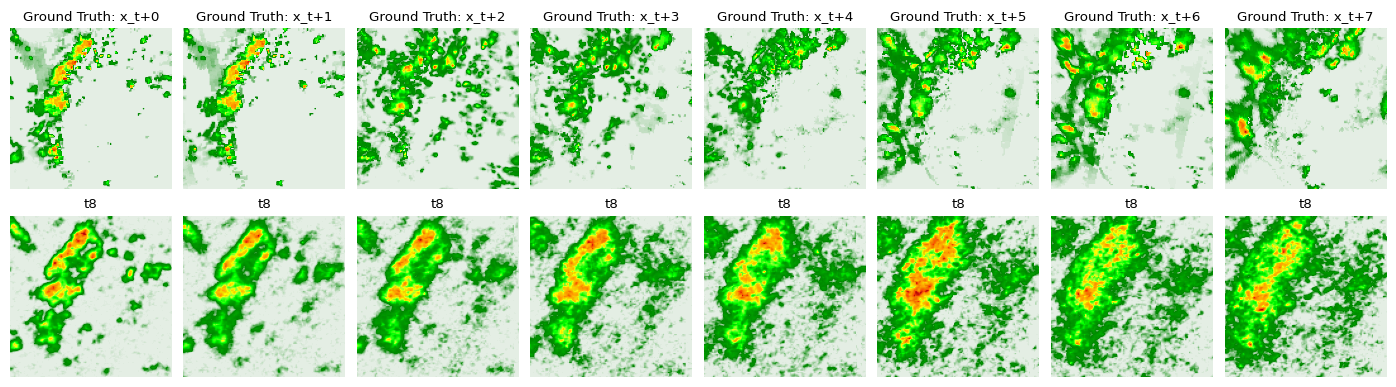

In [13]:
# plot the predictions:
c = 0
figsize = (14, 4)
plot_params = {"cmap": rain_cmap, "vmin": 0.5, "vmax": 18}

idx = 6

targets, predictions = results[idx]

fig, axs = plt.subplots(2, targets.size(0), figsize=figsize)
plt.rcParams.update(global_params)
# plot ground truth in the 1st row.
for j in range(targets.size(0)):
    axs[0, j].imshow(targets[j, c, ...], **{"cmap": rain_cmap})
    axs[0, j].set_title(f"Ground Truth: x_t+{j}")
# plot predictions.
for e, pred in enumerate(predictions):
    axs[1, e].imshow(pred, **{"cmap": rain_cmap})
    axs[1, e].set_title(f"{k}")
for ax in axs.flatten():
    ax.axis("off")

plt.tight_layout()

### END OF SCRIPT.